In [1]:
import os
import torch
import torchvision
import matplotlib
import matplotlib.pyplot as plt

import numpy as np

import torch.nn as nn
import torch.nn.functional as f
from torch.utils.data import DataLoader

from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torchvision.utils import make_grid

import tarfile 
%matplotlib inline

In [2]:
ur="https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(root=".",url=ur)

with tarfile.open("./cifar10.tgz","r:gz") as t:
    t.extractall(path="./data")

data_directory="./data/cifar10"
print(os.listdir(data_directory))
print(os.listdir(data_directory+"/train"))
print(os.listdir(data_directory+"/test"))

100.0%


['test', 'train']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [3]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tf = tt.Compose([tt.RandomCrop(32,padding=4,padding_mode="reflect"),
                      tt.RandomHorizontalFlip(),
                      tt.ToTensor(),
                      tt.Normalize(*stats,inplace=True)])
valid_tf = tt.Compose([tt.ToTensor(),tt.Normalize(*stats)])


In [4]:
train_ds = ImageFolder(data_directory+"/train",train_tf)
valid_ds = ImageFolder(data_directory+"/test",valid_tf)

In [5]:
train_dl = DataLoader(train_ds,batch_size=400,shuffle=True,num_workers=3,pin_memory=True)
valid_dl=DataLoader(train_ds,batch_size=800,num_workers=3,pin_memory=True)

In [6]:
def denormalize(img,means,stds):
    means=torch.tensor(means).reshape(1,3,1,1)
    stds=torch.tensor(stds).reshape(1,3,1,1)
    return img * stds + means
def showbatch(l):
    for img,label in l:
        plt.figure(figsize=(16,16))
        img=denormalize(img,*stats)
        plt.imshow(make_grid(img[:64],nrow=8).permute(1,2,0).clamp(0,1))
        break

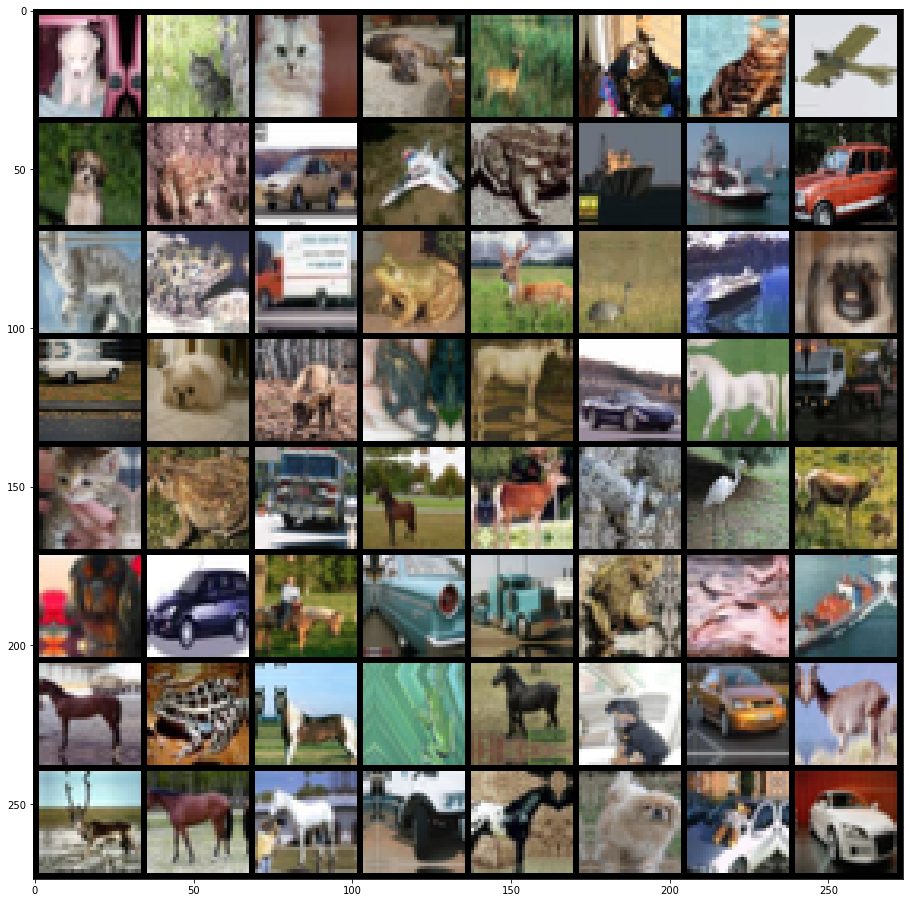

In [7]:
showbatch(train_dl)

In [8]:
def default_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")
    
def to_device(data, device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

class devicedataloader():
    def __init__(self,dl,device):
        self.dl=dl
        self.device=device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b,self.device)

    def __len__(self):
        return len(self.dl)


In [9]:
device = default_device()
device

device(type='cuda')

In [10]:
train_dl = devicedataloader(train_dl, device)
valid_dl = devicedataloader(valid_dl, device)

In [11]:
def accuracy(out,lab):
    _,preds=torch.max(out,dim=1)
    return torch.tensor(torch.sum(preds == lab).item()/len(preds))

class imgclass(nn.Module):

    def training_step(self,b):
        img,lab=b
        out=self.forward(img)
        loss=f.cross_entropy(out,lab)
        return loss
    
    def validation_step(self,b):
        img,lab=b
        out=self.forward(img)
        loss=f.cross_entropy(out,lab)
        acc=accuracy(out,lab)
        return {"accuracy":acc,"loss":loss}
    
    def validation_epoch_end(self,output):
        acc=[x["accuracy"] for x in output]
        acc=torch.stack(acc).mean()
        loss=[x["loss"] for x in output]
        loss=torch.stack(loss).mean()
        return {"val_acc":acc,"val_loss":loss}
    
    def epoch_end(self,epoch,out):
        print("Epoch:{} Accuracy:{} Loss:{} Lr:{}".format(epoch,out["val_acc"],out["val_loss"],out["lr"][-1]))
        

![](net.svg)

In [12]:
def conv(i,out,pool=False):
    layers=[nn.Conv2d(i,out,kernel_size=3,padding=1),nn.BatchNorm2d(out),nn.ReLU(inplace=True)]
    if pool==True: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class resnet9(imgclass):
    
    def __init__(self,i):
        super().__init__()
        self.conv1=conv(i,64)
        self.conv2=conv(64,128,pool=True)

        self.res1=nn.Sequential(conv(128,128),conv(128,128))

        self.conv3=conv(128,256,pool=True)
        self.conv4=conv(256,512,pool=True)

        self.res2=nn.Sequential(conv(512,512),conv(512,512))

        self.ll=nn.Sequential(nn.MaxPool2d(4),nn.Flatten(),nn.Dropout(0.2),nn.Linear(512,10))

    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)

        out=self.res1(out)+out

        out=self.conv3(out)
        out=self.conv4(out)

        out=self.res2(out)+out

        return self.ll(out)

In [13]:
model = to_device(resnet9(3),device)
model

resnet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [14]:
@torch.no_grad()
def evaluate(model,batch):
    model.eval()
    out=[model.validation_step(b) for b in batch ]
    return model.validation_epoch_end(out)

def get_lr(o):
    for param_group in o.param_groups:
        return param_group['lr']

def fit(model,train_l,valid_l,epoch=8,maxlr=0.01,grad_clip=None,weightdecay=None,opt_func=torch.optim.Adam):
    history=[]
    optimizer=opt_func(model.parameters(),maxlr,weight_decay=weightdecay)
    sch=torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer,max_lr=maxlr,epochs=epoch,steps_per_epoch=len(train_l))
    torch.cuda.empty_cache()
    for epo in range(epoch):
        model.train()
        lr=[]

        for batch in train_l:
            loss=model.training_step(batch)
            loss.backward()

            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()
            lr.append(get_lr(optimizer))
            sch.step()

        result=evaluate(model,valid_l)
        result["lr"]=lr
        model.epoch_end(epo,result)
        history.append(result)

    return history
            

In [15]:
evaluate(model,valid_dl)

{'val_acc': tensor(0.0913), 'val_loss': tensor(2.3056, device='cuda:0')}

In [16]:
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4


In [17]:
history = fit( model, train_dl, valid_dl,grad_clip=grad_clip,weightdecay=weight_decay)

Epoch:0 Accuracy:0.3578571081161499 Loss:2.5475473403930664 Lr:0.003929274947543202
Epoch:1 Accuracy:0.5519047975540161 Loss:1.3784301280975342 Lr:0.009352712767003208
Epoch:2 Accuracy:0.7592658400535583 Loss:0.7120043039321899 Lr:0.009719417773875232
Epoch:3 Accuracy:0.6998412609100342 Loss:0.8577036261558533 Lr:0.008117456539497631
Epoch:4 Accuracy:0.821488082408905 Loss:0.49748358130455017 Lr:0.005559840141227017
Epoch:5 Accuracy:0.8514879941940308 Loss:0.41857942938804626 Lr:0.0028306099820869924
Epoch:6 Accuracy:0.915654718875885 Loss:0.24534033238887787 Lr:0.0007664159383425639
Epoch:7 Accuracy:0.9347222447395325 Loss:0.1907714456319809 Lr:4e-08


In [28]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return train_ds.classes[preds[0].item()]


Label: airplane , Predicted: ship


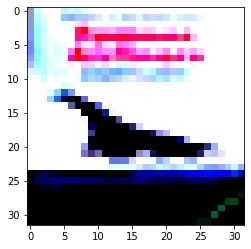

In [30]:
img, label = valid_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: automobile , Predicted: automobile


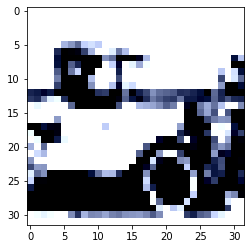

In [31]:
img, label = valid_ds[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', valid_ds.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: frog , Predicted: frog


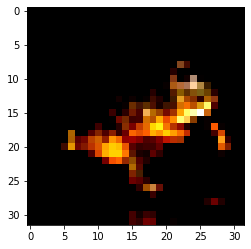

In [32]:
img, label = valid_ds[6153]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))